View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/

My Youtube Channel: https://www.youtube.com/user/MorvanZhou

More about Reinforcement learning: https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/

Dependencies:
- torch: 0.4
- gym: 0.8.1
- numpy

# Install
pip install gym
## Render Requirements:

sudo apt install xvfb
sudo apt install python-opengl
## Render to jupyter:

pip install jupyter
xvfb-run -s "-screen 0 600x400x24" jupyter-notebook Render-matplotlib.ipynb  
## Render to MP4:

sudo apt install ffmpeg
xvfb-run -s "-screen 0 600x400x24" python RenderToMP4.py

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym

# show state
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000
env = gym.make('CartPole-v0')
env = env.unwrapped
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
# to confirm the shape
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     

In [3]:
# import gym
# %matplotlib inline

# env = gym.make('CartPole-v0')
# env.reset()
# img = plt.imshow(env.render(mode='rgb_array')) # only call this once
# for _ in range(100):
#     img.set_data(env.render(mode='rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)

In [4]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [11]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
%%bash
export DISPLAY=localhost:0.0 

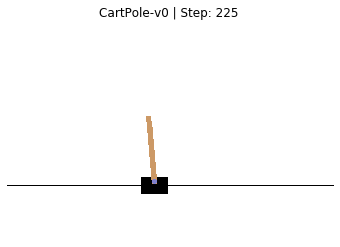

In [ ]:
%matplotlib inline
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    
dqn = DQN()

print('\nCollecting experience...')
for i_episode in range(400):
    s = env.reset()
    ep_r = 0
    while True:
        env.render()     
        a = dqn.choose_action(s)
        
        show_state(env, i_episode, "")   

        # take action
        s_, r, done, info = env.step(a)

        # modify the reward
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2

        dqn.store_transition(s, a, r, s_)

        ep_r += r
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            if done:
                print('Ep: ', i_episode,
                      '| Ep_r: ', round(ep_r, 2))

        if done:
            break
        s = s_